# ALE explanation using Heart Disease dataset

ALE, like PDP (Partial Dependence Plots) is a model agnostic technique useful for the explaining and visualizing the effects of each feature on the results of black box models. However, it is better compared to PDP as it addresses the primary drawbacks of the same. PD Plots ignore the correlation between the features and considers them to be independent which leads to erroneous results when the features of the dataset are highly correlated. ALE, on the other hand, produce good results in spite of there being a correlation between features and are also less computationally expensive. They visualise the effect that each feature, isolated from all other features, has on the predictions of the model. 

A second order ALE plot can also show the combined effects of multiple features on the outcome. 


In [1]:
!pip install alibi

     |████████████████████████████████| 327 kB 624 kB/s 
     |████████████████████████████████| 2.6 MB 10.4 MB/s 
     |████████████████████████████████| 93.8 MB 87 kB/s 
     |████████████████████████████████| 3.3 MB 15.3 MB/s 
     |████████████████████████████████| 40 kB 3.7 MB/s 
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.3.2-py2.py3-none-any.whl size=93807573 sha256=8123f9dadc89d33f30921053076284107781f27a9202d14f7cac5bbfd8c65001
  Stored in directory: /root/.cache/pip/wheels/53/c2/ca/b2496a732bb10cc3d4adea066bb3f9f427fb22a4df7aebbd76
Successfully built spacy-lookups-data
  Attempting uninstall: packaging
    Found existing installation: packaging 20.8
    Uninstalling packaging-20.8:
      Successfully uninstalled packaging-20.8
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.4
    Uninstalling tokenizers-0.9.4:
      Successfully uninstalled tokenizers-0.9.4
  Attempting uninstall: transformers
    Found existing ins

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from alibi.explainers.ale import ALE, plot_ale

Reading the Heart disease dataset

In [3]:
data = pd.read_csv('../input/heart-disease-cleveland-uci/heart_cleveland_upload.csv')
# To display the top 5 rows
data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [4]:
heart = data.copy()

In [5]:
target = 'condition'
features_list = list(heart.columns)
features_list.remove(target)

In [6]:
y = heart.pop('condition')

Splitting the data into training and testing set

In [7]:
X_train, X_test, y_train, y_test = train_test_split(heart, y, test_size=0.2, random_state=33)

# Using Logistic Regression Model

Fitting a logistic regression model

In [8]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Evaluation the model

In [9]:
accuracy_score(y_test, lr.predict(X_test))

0.9

The model gave a quite good accuracy.

Now we calculate the Accumulated Local Effects using Probability space :

In [10]:
proba_fun_lr = lr.predict_proba

In [11]:
proba_ale_lr = ALE(proba_fun_lr, feature_names=features_list, target_names=[0,1])

In [12]:
proba_exp_lr = proba_ale_lr.explain(X_train.values)

## Probability space

Plotting the ALE plots based on feature effects on the probabilities of each class

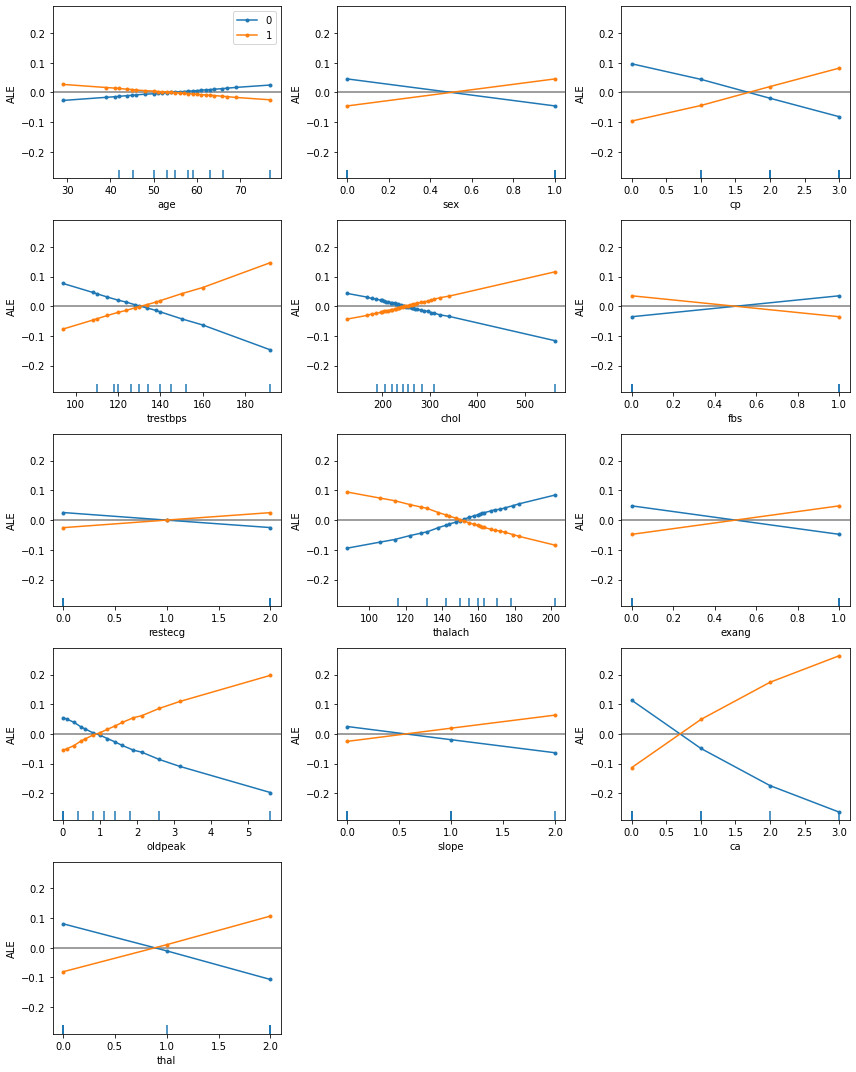

In [13]:
plot_ale(proba_exp_lr, n_cols=3, fig_kw={'figwidth': 12, 'figheight': 15});

The units of Y-axis (ALE) relative probability mass, i.e. given a feature value how much probability the model assigns to each class relative to the mean prediction.


Let us consider cp for example.

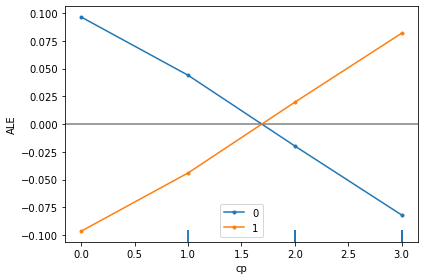

In [14]:
plot_ale(proba_exp_lr, features=[2]);

In this plot,the ALE lines cross the x-axis at approximately 1.6cm, which suggests that for instances of cp around ~1.6cm, the feature effect on the prediction is the same as the average feature effect. Also, going towards the extreme values of the feature, the model assigns a large positive value for 0 and  large negative penalty towards 3 for classification of "0" and vice versa for 1. In other words, the feature effect and the probability is more for instances of higher values of cp when the prediction is 1(having heart disease), and similarly when the cp value is lower, there is more probabolity of no heart disease, as expected.

Now we plot a histogram for cp

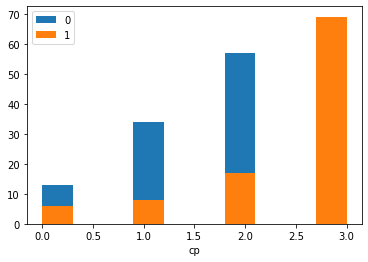

In [15]:
x_train=X_train.to_numpy()
fig, ax = plt.subplots()
for target in range(2):
    ax.hist(x_train[y_train==target][:,2],label=target);

ax.set_xlabel(features_list[2])
ax.legend();

It is clearly seen that as the cp value increases, more no of patients are likely to get the disease.

# 2. Using Gradient Boosting Model :

Now, we see the effects of ALE on a non linear model using Gradient Boosting.


In [16]:
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

Testing the accuracy.

In [18]:
accuracy_score(y_test, gb.predict(X_test))

0.85

The accuracy is good enough.


In [19]:
proba_fun_gb = gb.predict_proba

In [20]:
proba_ale_gb = ALE(proba_fun_gb, feature_names=features_list, target_names=['0','1'])

In [21]:
proba_exp_gb = proba_ale_gb.explain(X_train.values[:,:])

In [22]:
gb.feature_importances_

array([0.10235622, 0.01224798, 0.13783589, 0.07256721, 0.05850758,
       0.00203657, 0.00315263, 0.06164425, 0.01430168, 0.1366944 ,
       0.03709326, 0.16564765, 0.19591466])

By printing out the feature importances, it can be deduced that ca and thal are the most important features fbs and restecg are the least important.

Plotting the graphs for all features towards the probability space

array([[<AxesSubplot:xlabel='age', ylabel='ALE'>,
        <AxesSubplot:xlabel='sex', ylabel='ALE'>],
       [<AxesSubplot:xlabel='cp', ylabel='ALE'>,
        <AxesSubplot:xlabel='trestbps', ylabel='ALE'>],
       [<AxesSubplot:xlabel='chol', ylabel='ALE'>,
        <AxesSubplot:xlabel='fbs', ylabel='ALE'>],
       [<AxesSubplot:xlabel='restecg', ylabel='ALE'>,
        <AxesSubplot:xlabel='thalach', ylabel='ALE'>],
       [<AxesSubplot:xlabel='exang', ylabel='ALE'>,
        <AxesSubplot:xlabel='oldpeak', ylabel='ALE'>],
       [<AxesSubplot:xlabel='slope', ylabel='ALE'>,
        <AxesSubplot:xlabel='ca', ylabel='ALE'>],
       [<AxesSubplot:xlabel='thal', ylabel='ALE'>, None]], dtype=object)

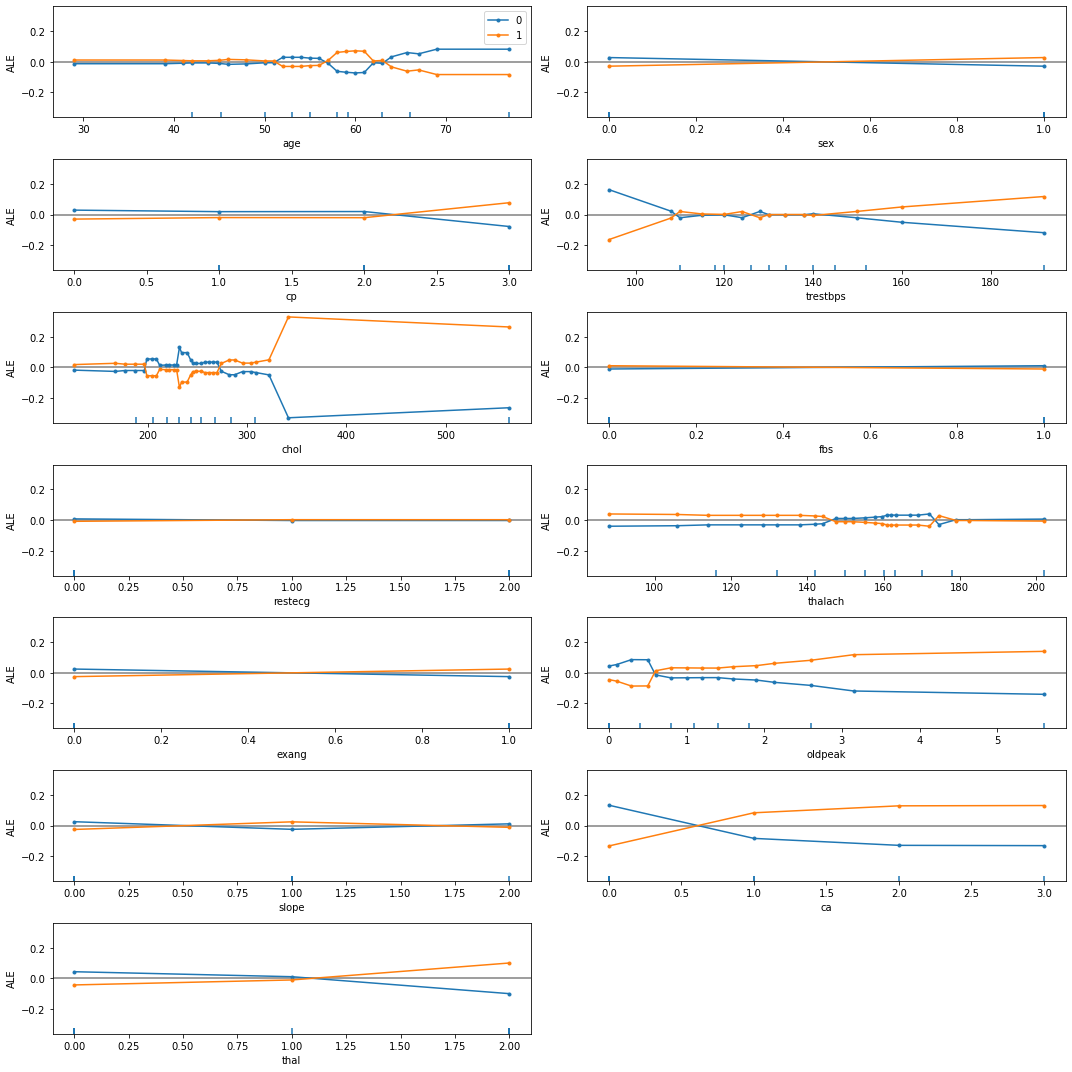

In [23]:
plot_ale(proba_exp_gb, n_cols=2, fig_kw={'figwidth': 15, 'figheight': 15})

Since gradient boosting is applied, the plots are no longer linear.
As seen in the above graphs, fbs and restecg have almost flat lines which clearly indicates that they are the least important features. In contrast, the plot of ca shows a quite increase in feature effect at higher levels of ca.


###Comparing Logistic Regression and Gradient Boosting

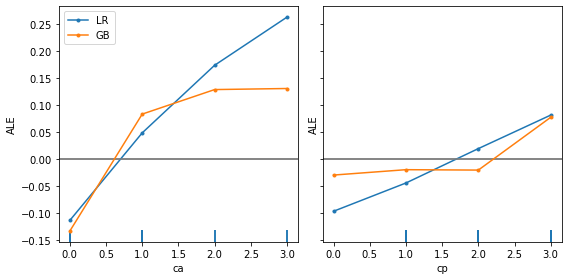

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='row');
plot_ale(proba_exp_lr, features=[11,2], targets=[1], ax=ax, line_kw={'label': 'LR'});
plot_ale(proba_exp_gb, features=[11,2], targets=[1], ax=ax, line_kw={'label': 'GB'});

We have considered 2 features namely, cp and ca. The following conclusions can be made from the above graphs:

1.   In both models, the feature weight of ca for predicting class '1' is high. It is increasing in nature an has a high positive influence at 3. From about 0 to 0.5 ca, the feature has a high negative influence on predicting the class '1'.
2.   Conversely, the second graph shows that the feature weight of cp has a high importance in the LR Model, but doesn't affect the predictions much on GB Model.

